### Librairies import

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import rank
from scipy import ndimage as ndi
from skimage.morphology import disk
import sklearn.metrics
from io import BytesIO
import PIL.Image
import zipfile
import skimage.io
from sklearn.cluster import KMeans

### Datasets import

In [2]:
from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df, df_get_ith_image

In [3]:
X_train, X_test, y_train = get_data()

#### X_train collected ####
#### X_test collected ####
#### y_train collected ####


### K means algorithm

In [4]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = X_train[:20]
labels_val = y_train.iloc[:20]

### Using scikit learn 

In [5]:
s = 0
n = 6
predictions = []
for image in data_val:
    flatten_image = image.reshape(image.shape[0] * image.shape[1], 1)
    kmeans = KMeans(n_clusters=n, random_state=0).fit(flatten_image)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    predictions.append(clustered)
    s = s+1
    print(f'{s}/20')

1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
20/20


In [6]:
sk_predictions_df = prediction_to_df(predictions).round()

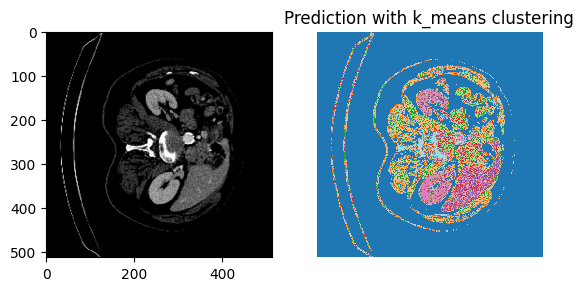

In [7]:
plot_slice_seg(data_val[0], predictions[0])
plt.title('Prediction with k_means clustering');

Text(0.5, 1.0, 'Prediction with k_means clustering rounded')

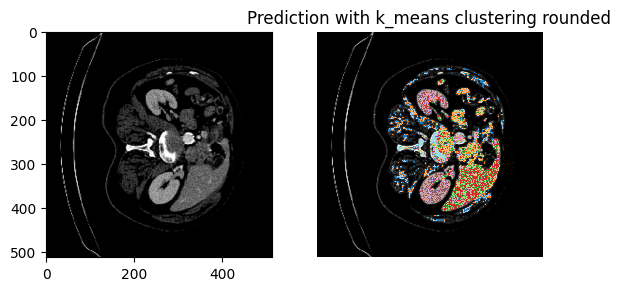

In [22]:
plot_slice_seg(data_val[0], sk_predictions_df.iloc[0].values.reshape((512,512)))
plt.title('Prediction with k_means clustering rounded');

In [15]:
round_pred = sk_predictions_df.iloc[0].values.reshape((512,512))
for x in range(512):
    for y in range(512):
        if round_pred[x, y] != 0.:
            round_pred[x, y] = 155.

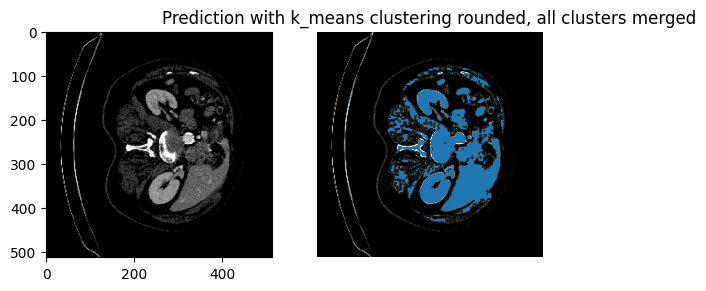

In [17]:
plot_slice_seg(data_val[0], round_pred)
plt.title('Prediction with k_means clustering rounded, all clusters merged');

We notice that the segmentation between brain parts and background is very good, but there's no homogeneity at all within clusters

In [30]:
rand_index_dataset(labels_val, sk_predictions_df.sample(20))

0.07298202444299311

### Using opencv, faster 

In [14]:
# reshape array to get the long list of RGB colors and then cluster using KMeans()
#image 2
attempts=2
predictions = []
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
s=0
for img in data_val:
    img_convert = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vectorized = img_convert.reshape((-1,3))
    vectorized = np.float32(vectorized)
    ret,label,center=cv2.kmeans(vectorized,2,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image1 = res.reshape((img_convert.shape))
    result_image1 = cv2.cvtColor(result_image1, cv2.COLOR_BGR2GRAY)
    predictions.append(result_image1)
    s=s+1
    if s%10 == 0:
        print(f"{s}/200")

10/200
20/200
30/200
40/200
50/200
60/200
70/200
80/200
90/200
100/200
110/200
120/200
130/200
140/200
150/200
160/200
170/200
180/200
190/200
200/200


In [26]:
predictions_df = prediction_to_df(predictions)

In [16]:
rand_index_dataset(labels_val, predictions_df.sample(200))

0.044870414221174146

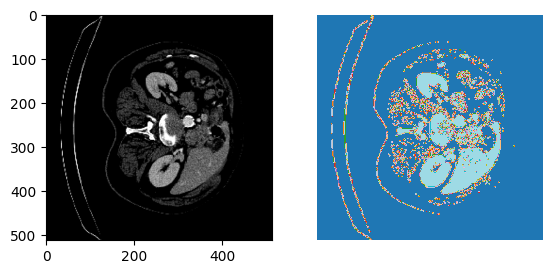

In [21]:
plot_slice_seg(X_train[0], predictions[0])